# Meter and tempo estimation on symbolic data

Meter, time signature, beat, downbeat, and tempo estimation form a group of related tasks. At first glance, many of them might seem trivial on symbolic music, after all the precise onsets of notes are known from the MIDI data. But with changing tempi and unknown measures it can be quite challenging. 

In [36]:
import partitura as pt
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [37]:
path_to_midi = os.path.join("..","introduction","example_data","Chopin_op10_no3_p01.mid")
ppart = pt.load_performance_midi(path_to_midi)[0]

In [38]:
note_array = ppart.note_array()

## Data Exploration - 1

let's have a look at the distribution of inter onset intervals!

(array([119.,  79.,  38.,  22.,  17.,   5.,   4.,   3.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   3.,   5.,   5.,   5.,   6.,  16.,   9.,
         10.,   9.,  10.,   5.,  10.,  10.,   5.,   5.,   6.,   3.,   3.,
          5.,   3.,   1.,   5.,   2.,   1.,   1.,   1.,   2.,   1.,   4.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.00967499, 0.01934998, 0.02902496, 0.03869995,
        0.04837494, 0.05804993, 0.06772491, 0.0773999 , 0.08707489,
        0.09674988, 0.10642487, 0.11609986, 0.12577485, 0.13544983,
        0.14512482, 0.1547998 , 0.16447479, 0.17414978, 0.18382476,
        0.19349976, 0.20317474, 0.21284974, 0.

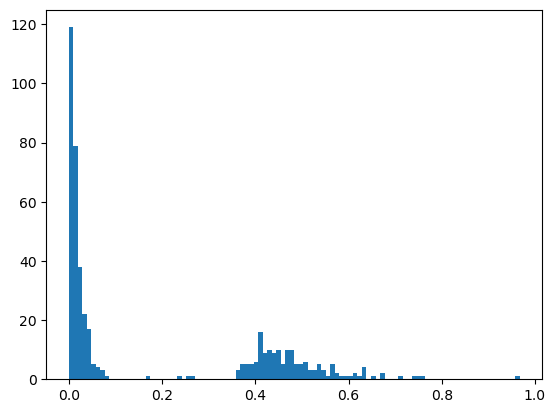

In [39]:
IOIs = np.diff(np.sort(note_array["onset_sec"]))
plt.hist(IOIs, bins = 100)

## Data Exploration - 2

There are many small inter onset intervals from musical notes that are played "simultaneously". For the task at hand, the spread or local deviations are not of interest, on the other hand, we would like to derive a common onset from notes that are notated in the same score position. Let's give it a try by converting the measured onsets to a framed unidimensional signal that contains the number of onsets in a performance in a small window in time, e.g. 20 ms

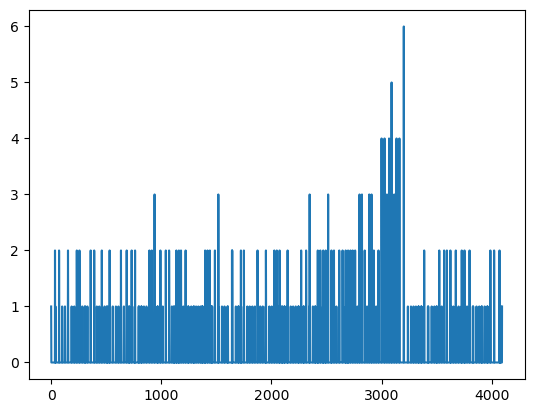

In [40]:
FRAMERATE = 50

onset_min = note_array["onset_sec"].min()
onset_max = note_array["onset_sec"].max()
onset_duration = onset_max - onset_min
frames = np.zeros(int(onset_duration*FRAMERATE)+1)
for note in note_array:
    frames[int((note["onset_sec"]-onset_min)*FRAMERATE)] += 1
    
plt.plot(frames)

## Data Exploration - 3

The previous aggregation is fairly noisy and for most cases doesn#t give good results, reason being the arbitrary cutoff in onset times between the frames. Let's try different frame generation process that aggregates very close onsets and at the same time encodes dynamics / quantity

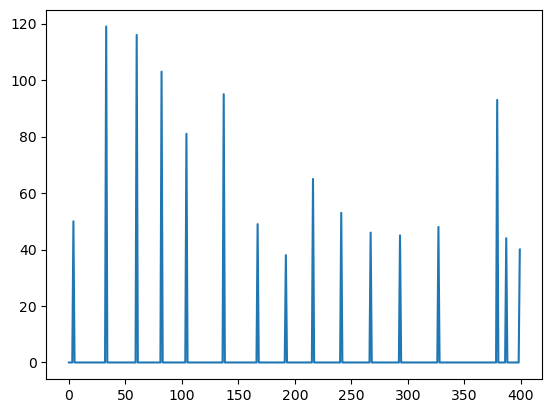

In [41]:
aggregated_notes = [(0,0)]
CHORD_SPREAD_TIME = 1/12 # a little faster than 16th notes at 180 bpm

for note in ppart.notes:
    prev_note_on = aggregated_notes[-1][0]
    note_on = note["note_on"]
    prev_note_vel = aggregated_notes[-1][1]
    if abs(note_on - prev_note_on) < CHORD_SPREAD_TIME:
        aggregated_notes[-1] = (note_on, prev_note_vel + note["velocity"]) # 1
        
    else:
        aggregated_notes.append((note_on, note["velocity"])) # 1
    
frames_a = np.zeros(int(onset_duration*FRAMERATE)+1)
for note in aggregated_notes:
    frames_a[int((note[0]-onset_min)*FRAMERATE)] += note[1]
    
frames_a[frames_a < 0.1] = 0.0
    
plt.plot(frames_a[-400:])

## Data Exploration - 4

ok, now that signal looks a lot more like approximately isochronous onsets, some with high velocity (sum of velocities occuring at this onset), some with lower. You can change the velocity to just a note count per onset to get an alternative onset value. 

One standard signal processing way of getting an estimate of the frequency of these onsets is to compute autocorrelation with increasing lag parameters. We plot the accumulated signal over time for different lag parameters to see at which lag the signal reinforces itself most strongly. How do we interpret these dimensions? The number of frames between onsets (= lag) is inversely proportional to the tempo of the onsets!

Besides visual analysis we can try some basic peak picking to get a numeric estimate of the frequency.

In [42]:
autocorr = np.zeros((4*FRAMERATE,frames_a.shape[0])  )
for framediff in range(1, 4*FRAMERATE+1):
    autocorr[framediff-1,framediff:] = frames_a[framediff:]*frames_a[:-framediff]

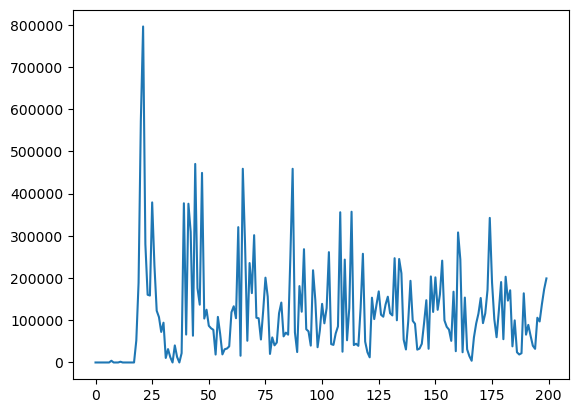

In [43]:
plt.plot(np.sum(autocorr, axis = 1))

In [44]:
from scipy.signal import find_peaks
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
a = find_peaks(np.sum(autocorr, axis = 1), prominence = 50)
m = np.argmax(np.sum(autocorr, axis = 1))
print(FRAMERATE/(21+1)*60, m)
print(a[0])

136.36363636363637 21
[  7  11  21  25  30  32  35  39  41  44  47  49  54  61  63  65  68  70
  75  78  82  84  87  90  92  96 100 103 108 110 113 115 118 122 125 129
 132 134 139 146 148 150 153 158 160 163 170 174 179 181 183 185 189 191
 195]


## Data Exploration - 5

Instead of the accumulated signal over the whole sequence, we could also aggregate the autocorrelation window-wise.

In [45]:
HOPSIZE = 10
WINDOWSIZE = 200
number_of_windows = int((autocorr.shape[1]-WINDOWSIZE)/HOPSIZE)
local_autocorr = np.zeros((autocorr.shape[0],number_of_windows))

for k in range(number_of_windows):
    local_autocorr[:,k] = np.sum(autocorr[:,k*HOPSIZE:k*HOPSIZE+WINDOWSIZE]
, axis = 1)    

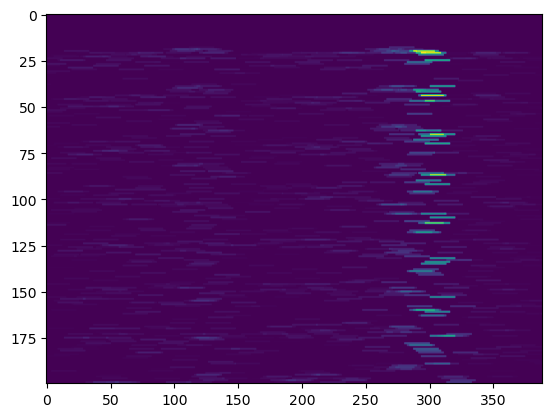

In [46]:
plt.imshow(local_autocorr*10, aspect="auto")

# Where to go from here?

Without more sophisticated methods it's hard to get a robust estimate of meter and tempo from this data. We introduce two possible approaches:
- Hidden Markov Model
- Agent-based Model

## HMM

A hidden model with a constant transition model and a state space encoding a measure in frames (1 measure = 100 states = 100 frames). The observation model produces onsets at states that encode 

In [47]:
from hiddenmarkov import HMM, ConstantTransitionModel, ObservationModel
import numpy as np
FRAMERATE=50

In [48]:
class MeterObservationModel(ObservationModel):
    def __init__(self, 
                 states = 100,
                 downbeat_idx = [0],
                 beat_idx = [50],
                 subbeat_idx = [25]
                ):
        super().__init__()
        self.states = states
        # observation 1 = note onset present, 0 = nothing present
        self.probabilities = np.ones((2,states))/100
        self.probabilities[0,:] = 0.99
        for idx in subbeat_idx:
            self.probabilities[:,idx] = [0.5, 0.5]
        for idx in beat_idx:
            self.probabilities[:,idx] = [0.3, 0.7]
        for idx in downbeat_idx:
            self.probabilities[:,idx] = [0.1, 0.9]
        self.db = downbeat_idx 
        self.b = beat_idx
        self.sb = subbeat_idx
        
    def get_beat_states(self, state_sequence):
        state_encoder = np.zeros_like(state_sequence)
        for i, state in enumerate(state_sequence):
            if state in self.sb:
                state_encoder[i] = 1
            if state in self.b:
                state_encoder[i] = 2
            if state in self.db:
                state_encoder[i] = 3
        return state_encoder
            
    def __call__(self, observation):
        
        if not self.use_log_probabilities:
            
            return self.probabilities[observation,:]
        else:
            return np.log(self.probabilities[observation,:])
            
def getTransitionMatrix(states, distribution=[0.1,0.8,0.1]):
    transition_matrix = np.eye(states,k=0) * distribution[0] + \
                        np.eye(states,k=1) * distribution[1] + \
                        np.eye(states,k=2) * distribution[2] + \
                        np.ones((states,states))/1e7
    transition_matrix[-2,0] = distribution[2]
    transition_matrix[-1,0] = distribution[2] + distribution[1]
    return transition_matrix

In [49]:
def createHMM(tempo=50, # frames_per_beat
              frame_rate = FRAMERATE,
              beats_per_measure=4, 
              subbeats_per_beat=2):
    frames_per_beat = 60/tempo*frame_rate 
    frames_per_measure = frames_per_beat * beats_per_measure
    states = int(frames_per_measure)
    downbeat_idx = [0]
    beat_idx = [int(states/beats_per_measure*k) for k in range(beats_per_measure)]
    subbeat_idx = [int(states/(beats_per_measure*subbeats_per_beat)*k) for k in range(beats_per_measure*subbeats_per_beat)]
    
    observation_model = MeterObservationModel(states = states,
                                             downbeat_idx = downbeat_idx,
                                             beat_idx = beat_idx,
                                             subbeat_idx = subbeat_idx)
    
    transition_matrix = getTransitionMatrix(states)
    transition_model = ConstantTransitionModel(transition_matrix)
    
    return observation_model, transition_model

In [50]:
observation_model, transition_model = createHMM(tempo=60, # bpm
                                                  frame_rate = FRAMERATE,
                                                  beats_per_measure=4, 
                                                  subbeats_per_beat=2)

hmm = HMM(observation_model=observation_model,
        transition_model=transition_model)
    
frames_a[frames_a < 1.0] = 0
frames_a[frames_a > 1.0] = 1

observations = np.array(frames_a, dtype=int)
path, log_lik = hmm.find_best_sequence(observations)

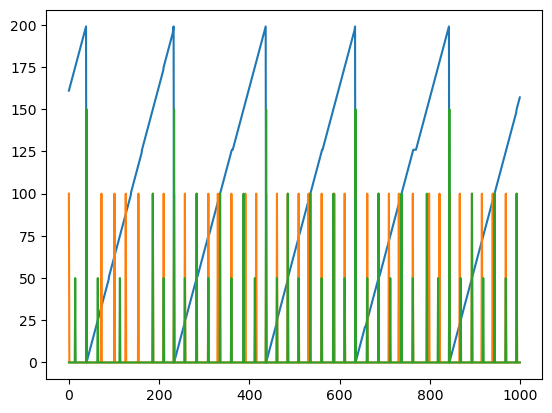

In [51]:
plt.plot(path[:1000])
plt.plot(observations[:1000]*100)
plt.plot(observation_model.get_beat_states(path)[:1000]*50)

## Agents

An agent-based algorithm based on the publication below. Implementation adapted from submission by Music Informatics 2021 student Jakob Wögerbauer.

..  Simon Dixon (2001), Automatic extraction of
    tempo and beat from expressive performances.
    Journal of New Music Research, 30(1):39–58

In [52]:
# Scaling factors
MAX = 9999999999999
MIN_INTERVAL = 0.01
MAX_INTERVAL = 2  # in seconds
CLUSTER_WIDTH = 1 / 12  # in seconds
N_CLUSTERS = 100
INIT_DURATION = 10  # in seconds
TIMEOUT = 10  # in seconds
TOLERANCE_POST = 0.4  # propotion of beat_interval
TOLERANCE_PRE = 0.2  # proportion of beat_interval
TOLERANCE_INNER = 1 / 12
CORRECTION_FACTOR = 1 / 4  # higher => more correction (speed changes)
MAX_AGENTS = 100  # delete low-scoring agents when there are more than MAX_AGENTS
CHORD_SPREAD_TIME = 1 / 12  # for onset aggregation

In [53]:
class MultipleAgents:
    """
    Class to compute inter onset interval clusters
    and to instantiate a number of agents to
    approximate beat positions.
    """

    def run(self, onsets, salience):
        self.clusters = []
        self.agents = []
        onsets = np.array(onsets)
        salience = np.array(salience)
        self.setup_clusters(onsets)
        self.init_tracking(onsets, salience)
        self.track(onsets, salience)

    def getTempo(self):
        if len(self.agents) == 0:
            return 120
        return self.agents[0].getTempo()

    def getNum(self):
        if len(self.agents) == 0:
            return 4
        return self.agents[0].getTimeSignatureNum()

    def getBeats(self):
        if len(self.agents) > 0:
            return self.agents[0].history
        return []

    def setup_clusters(self, onsets):
        # create inter-onset interval clusters
        self.clusters = []
        for i in range(len(onsets)):
            for j in range(i + 1, len(onsets)):
                ioi = onsets[j] - onsets[i]
                if ioi < MIN_INTERVAL:
                    continue
                if ioi > MAX_INTERVAL:
                    break
                c_min = False
                for c in self.clusters:
                    k = c.getK(ioi)
                    if k:
                        c_min = c
                if c_min:
                    c_min.addIoi(ioi)
                else:
                    self.clusters.append(Cluster(ioi))

        # merge clusters
        i = 0
        while i < len(self.clusters):
            c_i = self.clusters[i]
            i = i + 1
            j = i
            while j < len(self.clusters):
                if abs(c_i.interval - self.clusters[j].interval) < CLUSTER_WIDTH:
                    c_i.addIoi(self.clusters[j].iois)
                    self.clusters.remove(self.clusters[j])
                else:
                    j += 1

        # sanitize
        for c in self.clusters:
            if c.interval <= 0:
                continue
            while c.interval < MIN_INTERVAL:
                c.interval *= 2
            while c.interval > MAX_INTERVAL:
                c.interval /= 2

        # merge again
        i = 0
        while i < len(self.clusters):
            c_i = self.clusters[i]
            i = i + 1
            j = i
            while j < len(self.clusters):
                if abs(c_i.interval - self.clusters[j].interval) < CLUSTER_WIDTH:
                    c_i.addIoi(self.clusters[j].iois)
                    self.clusters.remove(self.clusters[j])
                else:
                    j += 1

        # calculate cluster scores
        for c_i in self.clusters:
            for c_j in self.clusters:
                n = round(c_j.interval / c_i.interval)
                if abs(c_i.interval - n * c_j.interval) < CLUSTER_WIDTH:
                    c_i.score += Cluster.relationship_factor(n) * len(c_j.iois)

        self.clusters = sorted(self.clusters, key=lambda x: x.score, reverse=True)[
            :N_CLUSTERS
        ]

    def init_tracking(self, onsets, salience):
        self.agents = []
        for c in self.clusters:
            i = 0
            while i < len(onsets) and onsets[i] < INIT_DURATION:
                a = Agent()
                a.beat_interval = c.interval
                a.history.append((onsets[i], salience[i]))
                a.prediction = onsets[i] + c.interval
                a.score = salience[i]
                self.agents.append(a)
                i += 1

    def track(self, onsets, salience):
        for e_i in range(len(onsets)):
            e = onsets[e_i]
            new_agents = []
            remove_agents = []
            for a in self.agents:
                if e - a.lastBeat() > TIMEOUT:
                    remove_agents.append(a)
                else:
                    while a.prediction + TOLERANCE_POST * a.beat_interval < e:
                        a.history.append((a.prediction, 0))
                        a.prediction += a.beat_interval
                    if (
                        a.prediction - TOLERANCE_PRE * a.beat_interval <= e
                        and e <= a.prediction + TOLERANCE_POST * a.beat_interval
                    ):
                        if abs(a.prediction - e) > TOLERANCE_INNER:
                            a_new = Agent()
                            a_new.beat_interval = a.beat_interval
                            a_new.history = a.history[:]
                            a_new.prediction = a.prediction
                            a_new.score = a.score
                            new_agents.append(a_new)
                        err = e - a.prediction
                        a.beat_interval = a.beat_interval + err * CORRECTION_FACTOR
                        a.prediction = e + a.beat_interval
                        a.history.append((e, salience[e_i]))
                        a.score += (1 - abs(err / a.beat_interval) / 2.0) * salience[
                            e_i
                        ]

            for a in remove_agents:
                self.agents.remove(a)
            self.agents = self.agents + new_agents

            # remove duplicate agents
            duplicate = np.zeros(len(self.agents))
            agents_all = self.agents[:]
            self.agents = []
            for i in range(len(agents_all)):
                for j in range(i + 1, len(agents_all)):
                    if duplicate[i] > 0 or duplicate[j] > 0:
                        continue

                    if (
                        abs(agents_all[i].beat_interval - agents_all[j].beat_interval)
                        < 0.01
                        and abs(agents_all[i].lastBeat() - agents_all[j].lastBeat())
                        < 0.02
                    ):
                        if agents_all[i].score > agents_all[j].score:
                            duplicate[j] += 1
                        else:
                            duplicate[i] += 1
                            break

            self.agents = sorted(
                np.asarray(agents_all)[(duplicate < 1)].tolist(),
                key=lambda x: x.score,
                reverse=True,
            )[:MAX_AGENTS]

        self.agents = sorted(self.agents, key=lambda x: x.score, reverse=True)


class Cluster:
    """
    Class for inter onset interval clusters.

    Parameters
    ----------
    ioi : float
        an initial inter onset interval

    """

    def __init__(self, ioi) -> None:
        self.iois = np.zeros(0)
        self.score = 0
        self.interval = 0
        self.addIoi(ioi)

    def getK(self, ioi):
        diff = abs(self.interval - ioi)
        if diff < CLUSTER_WIDTH:
            return diff
        return False

    def addIoi(self, ioi):
        self.iois = np.append(self.iois, ioi)
        self.interval = np.sum(self.iois) / len(self.iois)

    @staticmethod
    def relationship_factor(d):
        if 1 <= d and d <= 4:
            return 6 - d
        elif 5 <= d and d <= 8:
            return 1
        return 0

In [54]:
class Agent:
    """
    Class for beat induction agents.
    """

    def __init__(self) -> None:
        self.beat_interval = 0
        self.prediction = 0
        self.history = []
        self.score = 0

    def lastBeat(self):
        i = len(self.history) - 1
        while i > 0 and self.history[i][1] == 0:
            i -= 1
        return self.history[i][0]

    def getTempo(self):
        return (
            60.0 * (len(self.history) - 1) / (self.history[-1][0] - self.history[0][0])
        )

    def getTimeSignatureNum(self):
        possibleNums = [2, 3, 4, 6, 9, 12, 24]
        bestVal = {num: 0 for num in possibleNums}
        salience = list(zip(*self.history))[1]
        sumSalience = sum(salience)
        f = 1.005
        for num in possibleNums:
            for startIdx in range(num):
                dbs = len(salience[startIdx::num])
                if dbs > 1:
                    downbeatSalience = sum(salience[startIdx::num]) / dbs
                    sumSalience = sum(salience[: (dbs - 1) * num])
                    otherSalience = (sumSalience - downbeatSalience * dbs) / (
                        (num - 1) * (dbs - 1)
                    )
                else:
                    downbeatSalience = 0
                    otherSalience = 1

                ratio = downbeatSalience / otherSalience
                bestVal[num] = max(bestVal[num], ratio)

        bestNum = max(bestVal, key=bestVal.get)

        return bestNum

In [55]:
def estimate_time(note_array):
    """
    Estimate tempo, meter (currently only time signature numerator), and beats

    Parameters
    ----------
    note_array : structured array

    Returns
    -------
    dict
        Tempo, meter, and beat information
    """

    
    onsets_raw = note_array["onset_sec"]

    # aggregate notes in clusters
    aggregated_notes = [(0, 0)]
    for note_on in onsets_raw:
        prev_note_on = aggregated_notes[-1][0]
        prev_note_salience = aggregated_notes[-1][1]
        if abs(note_on - prev_note_on) < CHORD_SPREAD_TIME:
            aggregated_notes[-1] = (note_on, prev_note_salience + 1)
        else:
            aggregated_notes.append((note_on, 1))

    onsets, saliences = list(zip(*aggregated_notes))
    ma = MultipleAgents()
    ma.run(onsets, saliences)

    return dict(tempo=ma.getTempo(), meter_numerator=ma.getNum(), beats=ma.getBeats())

In [56]:
estimate_time(ppart.note_array())

{'tempo': 121.19147038899915,
 'meter_numerator': 24,
 'beats': [(5.776249885559082, 3),
  (6.446249961853027, 2),
  (7.012499809265137, 2),
  (7.518750190734863, 3),
  (8.09000015258789, 4),
  (8.731249809265137, 2),
  (9.207500457763672, 1),
  (9.670000076293945, 2),
  (10.140000343322754, 2),
  (10.65250015258789, 3),
  (11.175000190734863, 3),
  (11.59749984741211, 3),
  (12.197500228881836, 4),
  (12.821249961853027, 2),
  (13.306249618530273, 1),
  (13.738750457763672, 2),
  (14.212499618530273, 2),
  (14.708749771118164, 3),
  (15.176250457763672, 2),
  (15.62125015258789, 3),
  (16.193750381469727, 3),
  (16.7549991607666, 2),
  (17.22249984741211, 1),
  (17.6924991607666, 3),
  (18.22249984741211, 3),
  (18.729999542236328, 3),
  (19.186250686645508, 2),
  (19.6299991607666, 3),
  (20.251249313354492, 4),
  (20.956249237060547, 3),
  (21.415000915527344, 2),
  (21.864999771118164, 3),
  (22.31624984741211, 3),
  (22.853750228881836, 4),
  (23.311250686645508, 3),
  (23.7875003

# Improvements

Both presented approaches as well as the intial aggregation can be tuned and improved upon. Here are a few starting points:

- Preprocessing:
    - aggregation width
    - salience encoding; number of onsets, velocity, duration, ...
    - cluster based aggregation which update their means continually

- HMM:
    - more observation classes based on salience (instead of 0 = no onset and 1 = onset)
    - change transition probabilities for more or less flexible timing
    - add key and key strength estimation per onset (requires pitches per onset), use this information for downbeat and beat estimation
    
- Agents:
    - many hyperparameters to be tuned at the start of the last section
    - change relationship factor
    - incorporate aggregation in the cluster preprocessing
    - modify the agent method getTimeSignatureNum(), it contains several heuristics
    
Good luck!